# Кластеризация регионов России на основе показателей информатизации

## 1. Подготовка к кластеризации

Импортируем всё необходимое для анализа

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

Разрешим вывод неограниченного числа строк и столбцов

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Определим размеры графиков и отступ для меток

In [3]:
fig_size_1 = (10, 10)
fig_size_2 = (15, 7.5)
annot_offset = 0.05
np.random.seed(1024) # зафиксируем random seed для воспроизводимости

Загрузим статистические показатели, собранные с сайта [Федеральной службы государственной статистики](https://rosstat.gov.ru/)

In [4]:
dataset = pd.read_csv('informatization.csv', sep=';', decimal=',')

Посмотрим на первые несколько строк из набора данных

In [5]:
dataset.head()

,Субъект,Код субъекта,"Удельный вес организаций, использовавших персональные компьютеры, в процентах","Удельный вес организаций, использовавших Интернет, в процентах","Доля организаций, использующих сеть Интернет для размещения заказов на товары, работы, услуги","Доля организаций, имевших веб-сайт в сети Интернет","Доля органов власти, имеющих доступ в сеть Интернет со скоростью не менее 2 Мбит/сек","Доля учреждений здравоохранения, использующих сеть Интернет","Доля домашних хозяйств, имеющих компьютер","Доля домашних хозяйств, имеющих доступ к сети Интернет",Число пользователей сети Интернет на 100 человек населения,"Доля граждан, использующих механизм получения государственных и муниципальных услуг в электронной форме","Доля населения, являющегося активными пользователями сети Интернет","Доля населения, использовавшего сеть Интернет для заказа товаров и услуг","Доля населения, не использующего сеть Интернет по соображениям безопасности",Число квартирных телефонных аппаратов на 1000 человек населения в городской местности,Число квартирных телефонных аппаратов на 1000 человек населения в сельской местности,Число абонентских устройств сотовой связи на 1000 человек населения,"Затраты на информационные и коммуникационные технологии, в расчете на одного жителя, тысяч рублей","Объем оказанных населению услуг связи, в расчете на одного жителя, рублей"
0,Алтайский край,АЛТ,96.2,94.2,41.7,44.6,59.1,97.9,67.40,76.0,80.0,70.8,78.90,33.6,0.6,119.7,141.5,1719.1,2.28,5495.6
1,Амурская область,АМУ,95.1,91.7,40.1,41.7,55.6,97.1,61.50,74.7,81.0,76.2,79.90,27.1,0.0,78.6,32.7,1657.9,3.80,7661.6
2,Архангельская область,АРХ,94.9,88.7,42.1,48.1,67.2,96.3,74.59,77.5,81.0,82.2,81.09,37.6,0.1,88.9,80.2,NaN,2.75,6461.3
3,Астраханская область,АСТ,95.7,93.8,46.3,51.3,72.3,95.6,76.09,79.5,85.0,84.4,84.30,35.6,0.2,83.1,61.4,1750.6,3.76,5254.1
4,Белгородская область,БЕЛ,98.2,96.7,52.5,58.7,70.3,100.0,62.70,70.9,78.0,84.3,77.00,38.4,0.4,146.6,87.5,1894.2,3.06,5258.1


Ознакомимся с перечнем метрик из набора данных

In [6]:
for column in dataset.columns:
    print(column)

Субъект
Код субъекта
Удельный вес организаций, использовавших персональные компьютеры, в процентах
Удельный вес организаций, использовавших Интернет, в процентах
Доля организаций, использующих сеть Интернет для размещения заказов на товары, работы, услуги
Доля организаций, имевших веб-сайт в сети Интернет
Доля органов власти, имеющих доступ в сеть Интернет со скоростью не менее 2 Мбит/сек
Доля учреждений здравоохранения, использующих сеть Интернет
Доля домашних хозяйств, имеющих компьютер
Доля домашних хозяйств, имеющих доступ к сети Интернет
Число пользователей сети Интернет на 100 человек населения
Доля граждан, использующих механизм получения государственных и муниципальных услуг в электронной форме
Доля населения, являющегося активными пользователями сети Интернет
Доля населения, использовавшего сеть Интернет для заказа товаров и услуг
Доля населения, не использующего сеть Интернет по соображениям безопасности
Число квартирных телефонных аппаратов на 1000 человек населения в городс

In [7]:
samples = dataset.drop(['Субъект', 'Код субъекта'], axis=1).to_numpy()

print(f'Число строк: {samples.shape[0]}, число столбцов: {samples.shape[1]}')

regions = dataset['Субъект'].to_numpy()

codes = dataset['Код субъекта'].to_numpy()

Число строк: 85, число столбцов: 18


Заполним пропуски средними значениями той или иной метрики, чтобы не удалять весь регион

In [8]:
imputer = SimpleImputer(strategy='mean')

samples = imputer.fit_transform(samples)

Масштабируем значения, чтобы каждая метрика оказывала одинаковое влияние на результат

In [9]:
scaler = StandardScaler()

samples = scaler.fit_transform(samples)

Применим алгоритм t-SNE к набору данных, что позволит визуализировать многомерные данные

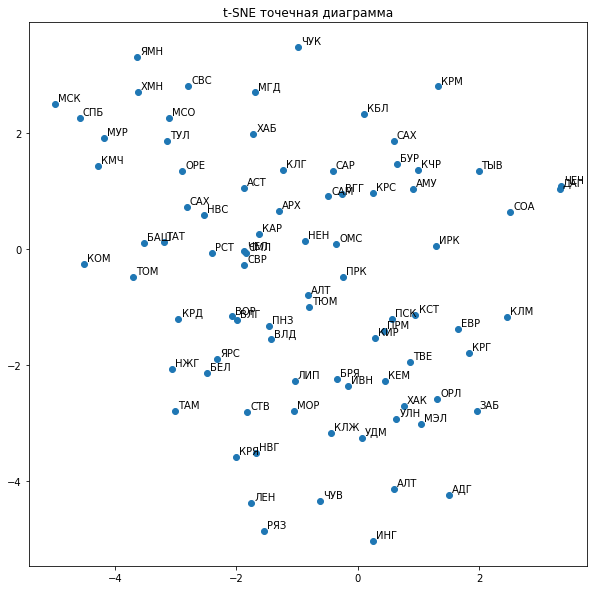

In [10]:
transformer = TSNE(learning_rate=100)

embedded = transformer.fit_transform(samples)

xs = embedded[:,0]
ys = embedded[:,1]

plt.rcParams['figure.figsize'] = fig_size_1

plt.scatter(xs, ys)

for x, y, code in zip(xs, ys, codes):
    plt.annotate(code, (x + annot_offset, y + annot_offset))

plt.title('t-SNE точечная диаграмма')

plt.show()

## 2. Кластеризация методом k-средних

Применим локтевой метод (elbow method), чтобы определить оптимальное число кластеров

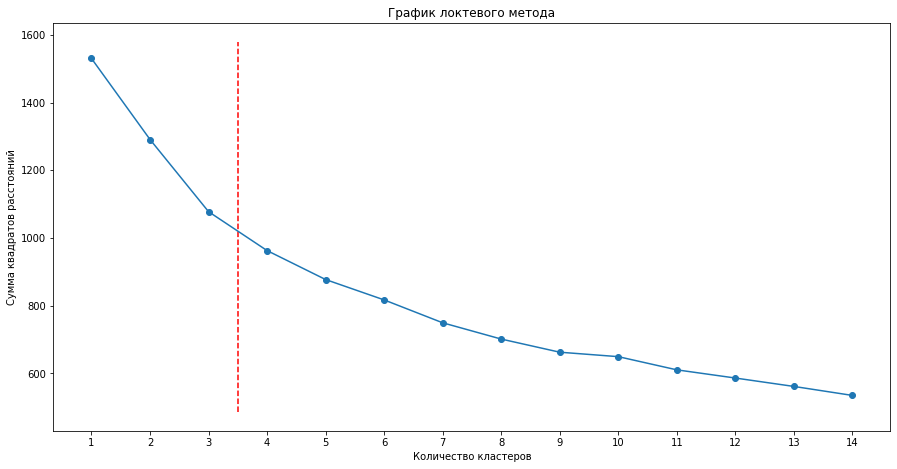

In [11]:
k_range = range(1, 15)

n_clusters = 3 # оптимальное число кластеров определено с помощью локтевого метода

inertias = []

for k in k_range:
    model = KMeans(n_clusters=k)
    model.fit(samples)
    inertias.append(model.inertia_)

plt.rcParams['figure.figsize'] = fig_size_2

plt.plot(k_range, inertias, '-o')
plt.xlabel('Количество кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.xticks(k_range)
plt.vlines(n_clusters + 0.5, *plt.ylim(), colors='r', linestyles='dashed')
plt.title('График локтевого метода')

plt.show()

Применим метод k-средних для кластеризации регионов и визуализируем кластеры

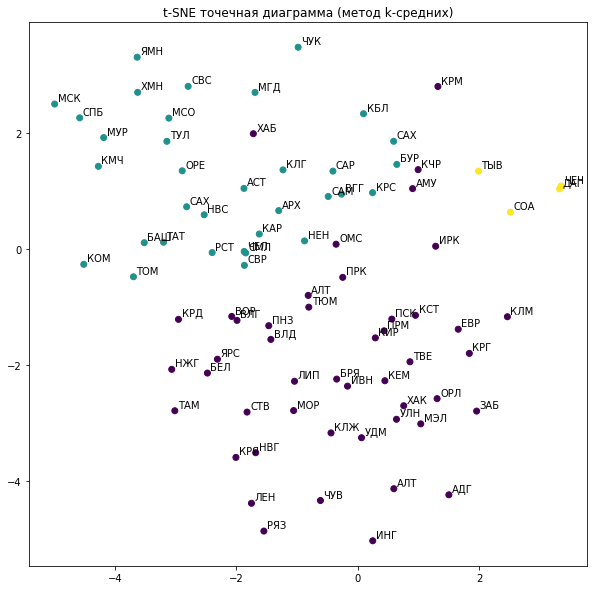

In [12]:
model = KMeans(n_clusters=n_clusters)

kmeans_labels = model.fit_predict(samples)

plt.rcParams['figure.figsize'] = fig_size_1

plt.scatter(xs, ys, c=kmeans_labels)

for x, y, code in zip(xs, ys, codes):
    plt.annotate(code, (x + annot_offset, y + annot_offset))

plt.title('t-SNE точечная диаграмма (метод k-средних)')

plt.show()

In [13]:
# Посмотрим на результаты кластеризации методом k-средних
# dataset['Кластер (метод k-средних)'] = pd.Series(kmeans_labels + 1)
# dataset[['Субъект', 'Кластер (метод k-средних)']].sort_values(['Кластер (метод k-средних)', 'Субъект'])

## 3. Кластеризация методом иерархий

Рассчитаем матрицу расстояний и построим дендрограмму

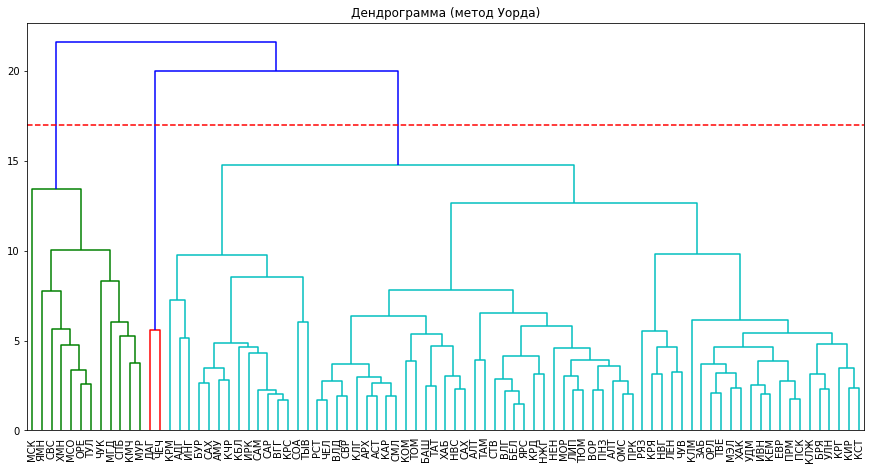

In [14]:
linkage_method = 'ward' # метод связи выбран опытным путём

threshold = 17 # значение порога выбрано опытным путём

mergings = linkage(samples, method=linkage_method)

plt.rcParams['figure.figsize'] = fig_size_2

dendrogram(mergings, labels=codes, leaf_rotation=90, leaf_font_size=10)

plt.hlines(threshold, *plt.xlim(), colors='r', linestyles='dashed')

plt.title('Дендрограмма (метод Уорда)')

plt.show()

Применим метод иерархической кластеризации и визуализируем кластеры

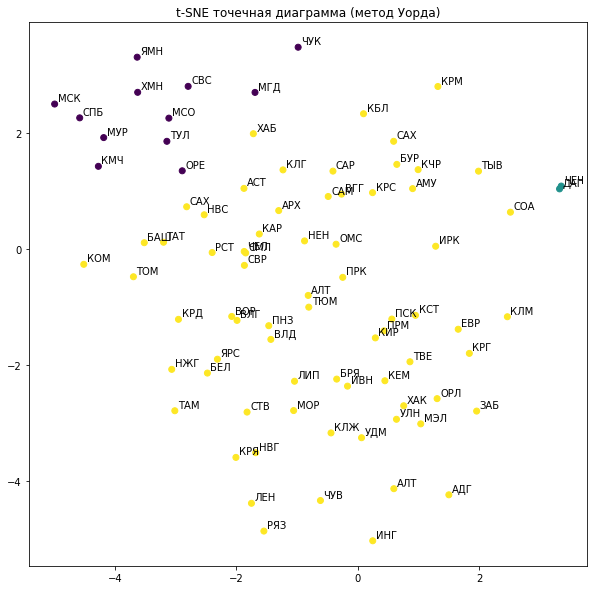

In [15]:
dendrogram_labels = fcluster(mergings, threshold, criterion='distance')

plt.rcParams['figure.figsize'] = fig_size_1

plt.scatter(xs, ys, c=dendrogram_labels)

for x, y, code in zip(xs, ys, codes):
    plt.annotate(code, (x + annot_offset, y + annot_offset))

plt.title('t-SNE точечная диаграмма (метод Уорда)')

plt.show()

In [16]:
# Посмотрим на результаты кластеризации методом иерархической кластеризации
# dataset['Кластер (метод Уорда)'] = pd.Series(dendrogram_labels)
# dataset[['Субъект', 'Кластер (метод Уорда)']].sort_values(['Кластер (метод Уорда)', 'Субъект'])

## 4. Выводы из результатов

По результатам кластеризации все регионы России были разделены на 3 группы. Тем не менее границы между кластерами нельзя назвать чёткими.

В первый кластер вошли регионы, которые отличаются высокими показателями информатизации. Это города федерального значения - Москва и Санкт-Петербург, а также экспорто-ориентированные и динамично развивающиеся регионы.

Второй кластер является наиболее многочисленным и включает в себя регионы со средними показателями информатизации. В том числе в него входит и Республика Мордовия.

Третий кластер представлен преимущественно субъектами Северо-Кавказского федерального округа и характеризуется более низкими метриками информатизации.